In [1]:
"""
Shor's Order Finding Algorithm Benchmark - Qiskit
"""

import math
import sys
import time

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

sys.path[1:1] = ["_common", "_common/qiskit", "shors/_common", "quantum-fourier-transform/qiskit"]
sys.path[1:1] = ["../../_common", "../../_common/qiskit", "../../shors/_common", "../../quantum-fourier-transform/qiskit"]
import execute as ex
import metrics as metrics
from shors_utils import getAngles, getAngle, modinv, generate_base, verify_order
from qft_benchmark import inv_qft_gate
from qft_benchmark import qft_gate

# Benchmark Name
benchmark_name = "Shor's Order Finding"

np.random.seed(0)

verbose = False

QC_ = None
PHIADD_ = None
CCPHIADDMODN_ = None
CMULTAMODN_ = None
CUA_ = None
QFT_ = None


In [2]:

############### Circuit Definition

#Creation of the circuit that performs addition by a in Fourier Space
#Can also be used for subtraction by setting the parameter inv to a value different from 0
def phiADD(num_qubits, a):

    qc = QuantumCircuit(num_qubits, name = "\u03C6ADD")

    angle = getAngles(a, num_qubits)
    for i in range(0, num_qubits):
        # addition
        qc.p(angle[i], i)

    global PHIADD_
    if PHIADD_ == None or num_qubits <= 3:
        if num_qubits < 4: PHIADD_ = qc

    return qc

#Single controlled version of the phiADD circuit
def cphiADD(num_qubits, a):
    phiadd_gate = phiADD(num_qubits,a).to_gate()
    cphiadd_gate = phiadd_gate.control(1)
    return cphiadd_gate

#Doubly controlled version of the phiADD circuit
def ccphiADD(num_qubits, a):
    phiadd_gate = phiADD(num_qubits,a).to_gate()
    ccphiadd_gate = phiadd_gate.control(2)
    return ccphiadd_gate

# Circuit that implements doubly controlled modular addition by a (num qubits should be bit count for number N)
def ccphiADDmodN(num_qubits, a, N):
    qr_ctl = QuantumRegister(2)
    qr_main = QuantumRegister(num_qubits+1)
    qr_ancilla = QuantumRegister(1)
    qc = QuantumCircuit(qr_ctl, qr_main,qr_ancilla, name = "cc\u03C6ADDmodN")

    # Generate relevant gates for circuit
    ccphiadda_gate = ccphiADD(num_qubits+1, a)
    ccphiadda_inv_gate = ccphiADD(num_qubits+1, a).inverse()
    phiaddN_inv_gate = phiADD(num_qubits+1, N).inverse(); phiaddN_inv_gate.name = "inv_\u03C6ADD"
    cphiaddN_gate = cphiADD(num_qubits+1, N)

    # Create relevant temporary qubit lists
    ctl_main_qubits = [i for i in qr_ctl]; ctl_main_qubits.extend([i for i in qr_main])
    anc_main_qubits = [qr_ancilla[0]]; anc_main_qubits.extend([i for i in qr_main])

    #Create circuit
    qc.append(ccphiadda_gate, ctl_main_qubits)
    qc.append(phiaddN_inv_gate, qr_main)

    qc.append(inv_qft_gate(num_qubits+1), qr_main)
    qc.cx(qr_main[-1], qr_ancilla[0])
    qc.append(qft_gate(num_qubits+1), qr_main)

    qc.append(cphiaddN_gate, anc_main_qubits)
    qc.append(ccphiadda_inv_gate, ctl_main_qubits)

    qc.append(inv_qft_gate(num_qubits+1), qr_main)

    qc.x(qr_main[-1])
    qc.cx(qr_main[-1], qr_ancilla[0])
    qc.x(qr_main[-1])

    qc.append(qft_gate(num_qubits+1), qr_main)

    qc.append(ccphiadda_gate, ctl_main_qubits)

    global CCPHIADDMODN_
    if CCPHIADDMODN_ == None or num_qubits <= 2:
        if num_qubits < 3: CCPHIADDMODN_ = qc

    return qc

# Circuit that implements the inverse of doubly controlled modular addition by a
def ccphiADDmodN_inv(num_qubits, a, N):
    cchpiAddmodN_circ = ccphiADDmodN(num_qubits, a, N)
    cchpiAddmodN_inv_circ = cchpiAddmodN_circ.inverse()
    cchpiAddmodN_inv_circ.name = "inv_cchpiAddmodN"
    return  cchpiAddmodN_inv_circ

# Creates circuit that implements single controlled modular multiplication by a. n represents the number of bits
# needed to represent the integer number N
def cMULTamodN(n, a, N):
    qr_ctl = QuantumRegister(1)
    qr_x = QuantumRegister(n)
    qr_main = QuantumRegister(n+1)
    qr_ancilla = QuantumRegister(1)
    qc = QuantumCircuit(qr_ctl, qr_x, qr_main,qr_ancilla, name = "cMULTamodN")

    # quantum Fourier transform only on auxillary qubits
    qc.append(qft_gate(n+1), qr_main)

    for i in range(n):
        ccphiADDmodN_gate = ccphiADDmodN(n, (2**i)*a % N, N)

        # Create relevant temporary qubit list
        qubits = [qr_ctl[0]]; qubits.extend([qr_x[i]])
        qubits.extend([i for i in qr_main]); qubits.extend([qr_ancilla[0]])

        qc.append(ccphiADDmodN_gate, qubits)

    # inverse quantum Fourier transform only on auxillary qubits
    qc.append(inv_qft_gate(n+1), qr_main)

    global CMULTAMODN_
    if CMULTAMODN_ == None or n <= 2:
        if n < 3: CMULTAMODN_ = qc

    return qc

# Creates circuit that implements single controlled Ua gate. n represents the number of bits
# needed to represent the integer number N
def controlled_Ua(n,a,exponent,N):
    qr_ctl = QuantumRegister(1)
    qr_x = QuantumRegister(n)
    qr_main = QuantumRegister(n)
    qr_ancilla = QuantumRegister(2)
    qc = QuantumCircuit(qr_ctl, qr_x, qr_main,qr_ancilla, name = f"C-U^{a**exponent}")

    # Generate Gates
    a_inv = modinv(a**exponent,N)
    cMULTamodN_gate = cMULTamodN(n, a**exponent, N)
    cMULTamodN_inv_gate = cMULTamodN(n, a_inv, N).inverse(); cMULTamodN_inv_gate.name = "inv_cMULTamodN"

    # Create relevant temporary qubit list
    qubits = [i for i in qr_ctl]; qubits.extend([i for i in qr_x]); qubits.extend([i for i in qr_main])
    qubits.extend([i for i in qr_ancilla])

    qc.append(cMULTamodN_gate, qubits)

    for i in range(n):
        qc.cswap(qr_ctl, qr_x[i], qr_main[i])

    qc.append(cMULTamodN_inv_gate, qubits)

    global CUA_
    if CUA_ == None or n <= 2:
        if n < 3: CUA_ = qc

    return qc

# Execute Shor's Order Finding Algorithm given a 'number' to factor,
# the 'base' of exponentiation, and the number of qubits required 'input_size'

def ShorsAlgorithm(number, base, method, verbose=verbose):
    
    # Create count of qubits to use to represent the number to factor
    # NOTE: this should match the number of bits required to represent (number)
    n = int(math.ceil(math.log(number, 2)))

    # Standard Shors Algorithm
    if method == 1:
        num_qubits = 4*n + 2

        if verbose:
            print(f"... running Shors to find order of [ {base}^x mod {number} ] using num_qubits={num_qubits}")

        # Create a circuit and allocate necessary qubits
        qr_counting = QuantumRegister(2*n)        # Register for sequential QFT
        qr_mult = QuantumRegister(n)        # Register for multiplications
        qr_aux = QuantumRegister(n+2)       # Register for addition and multiplication
        cr_data = ClassicalRegister(2*n)  # Register for measured values of QFT
        qc = QuantumCircuit(qr_counting, qr_mult, qr_aux, cr_data,
                name=f"qmc({method})-{num_qubits}-{number}")

        # Initialize multiplication register to 1 and counting register to superposition state
        qc.h(qr_counting)
        qc.x(qr_mult[0])

        qc.barrier()

        # Apply Multiplication Gates for exponentiation
        for i in reversed(range(2*n)):
            cUa_gate = controlled_Ua(n,int(base),2**(2*n-1-i),number)

            # Create relevant temporary qubit list
            qubits = [qr_counting[i]]; qubits.extend([i for i in qr_mult]);qubits.extend([i for i in qr_aux])

            qc.append(cUa_gate, qubits)

        qc.barrier()

        qc.append(inv_qft_gate(2*n),qr_counting)

        # Measure counting register
        qc.measure(qr_counting, cr_data)

    elif method == 2:

        # Create a circuit and allocate necessary qubits
        num_qubits = 2*n + 3

        if verbose:
            print(f"... running Shors to find order of [ {base}^x mod {number} ] using num_qubits={num_qubits}")

        qr_counting = QuantumRegister(1)        # Single qubit for sequential QFT
        qr_mult = QuantumRegister(n)      # Register for multiplications
        qr_aux = QuantumRegister(n+2)     # Register for addition and multiplication
        cr_data = ClassicalRegister(2*n)  # Register for measured values of QFT
        cr_aux = ClassicalRegister(1)     # Register to reset the state of the up register based on previous measurements
        qc = QuantumCircuit(qr_counting, qr_mult, qr_aux, cr_data, cr_aux, name="main")

        # Initialize mult register to 1
        qc.x(qr_mult[0])

        # perform modular exponentiation 2*n times
        for k in range(2*n):
            qc.barrier()

            # Reset the counting qubit to 0 if the previous measurement was 1
            qc.x(qr_counting).c_if(cr_aux,1)
            qc.h(qr_counting)

            cUa_gate = controlled_Ua(n, base,2**(2*n-1-k), number)

            # Create relevant temporary qubit list
            qubits = [qr_counting[0]]; qubits.extend([i for i in qr_mult]);qubits.extend([i for i in qr_aux])

            qc.append(cUa_gate, qubits)

            # perform inverse QFT --> Rotations conditioned on previous outcomes
            for i in range(2**k):
                qc.p(getAngle(i, k), qr_counting[0]).c_if(cr_data, i)

            qc.h(qr_counting)
            qc.measure(qr_counting[0], cr_data[k])
            qc.measure(qr_counting[0], cr_aux[0])

    global QC_, QFT_
    if QC_ == None or n <= 2:
        if n < 3: QC_ = qc
    if QFT_ == None or n <= 2:
        if n < 3: QFT_ = qft_gate(n+1)

    return qc


In [3]:

############### Circuit end

def expected_shor_dist(num_bits, order, num_shots):
    # num_bits represent the number of bits to represent the number N in question

    # Qubits measureed always 2 * num_bits for the three methods implemented in this benchmark
    qubits_measured = 2 * num_bits
    dist = {}

    #Conver float to int
    r = int(order)

    #Generate expected distribution
    q = int(2 ** (qubits_measured))

    for i in range(r):
        key = bin(int(q*(i/r)))[2:].zfill(qubits_measured)
        dist[key] = num_shots/r

        '''
            for c in range(2 ** qubits_measured):
                key = bin(c)[2:].zfill(qubits_measured)
                amp = 0
                for i in range(int(q/r) - 1):
                    amp += np.exp(2*math.pi* 1j * i * (r * c % q)/q )
                amp = amp * np.sqrt(r) / q
                dist[key] = abs(amp) ** 2
        '''
    return dist

# Print analyzed results
# Analyze and print measured results
# Expected result is always the order r, so fidelity calc is simple
def analyze_and_print_result(qc, result, num_qubits, order, num_shots, method):

    if  method == 1:
        num_bits = int((num_qubits - 2) / 4)
    elif method == 2:
        num_bits = int((num_qubits - 3) / 2)
    elif method == 3:
        num_bits = int((num_qubits - 2) / 2)

    # obtain bit_counts from the result object
    counts = result.get_counts(qc)

    # Only classical data qubits are important and removing first auxiliary qubit from count
    if method == 2:
        temp_counts = {}
        for key, item in counts.items():
            temp_counts[key[2:]] = item
        counts = temp_counts

    # generate correct distribution
    correct_dist = expected_shor_dist(num_bits, order, num_shots)

    if verbose:
        print(f"For order value {order}, measured: {counts}")
        print(f"For order value {order}, correct_dist: {correct_dist}")

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    return counts, fidelity       


Shor's Order Finding (1) Benchmark - Qiskit
... execution starting at Oct 07, 2024 04:02:24 UTC
************
Executing [1] circuits with num_qubits = 10
************
Executing [1] circuits with num_qubits = 14
************
Average Circuit Algorithmic Depth, ξ (xi) for the 10 qubit group = 904, 0.536
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 10 qubit group = 2732, 0.425, 1644.0
Average Creation, Elapsed, Execution Time for the 10 qubit group = 0.17, 4.149, 0.713 secs
Average Transpiling, Validating, Running Times for group 10 = 0.001, 0.001, 0.001 secs
Average Hellinger, Normalized Fidelity for the 10 qubit group = 1.0, 1.0

************
Executing [1] circuits with num_qubits = 18
************
Average Circuit Algorithmic Depth, ξ (xi) for the 14 qubit group = 2759, 0.588
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 14 qubit group = 8196, 0.43, 5070.0
Average Creation, Elapsed, Execution Time for the 14 qubit group = 1.145, 41.98, 32.872 secs
Average 

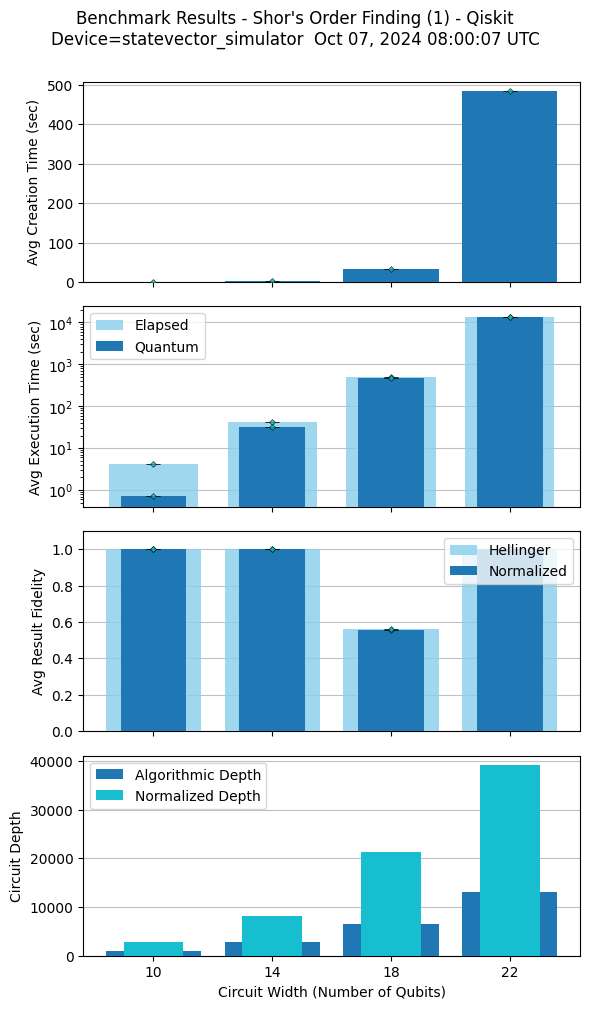

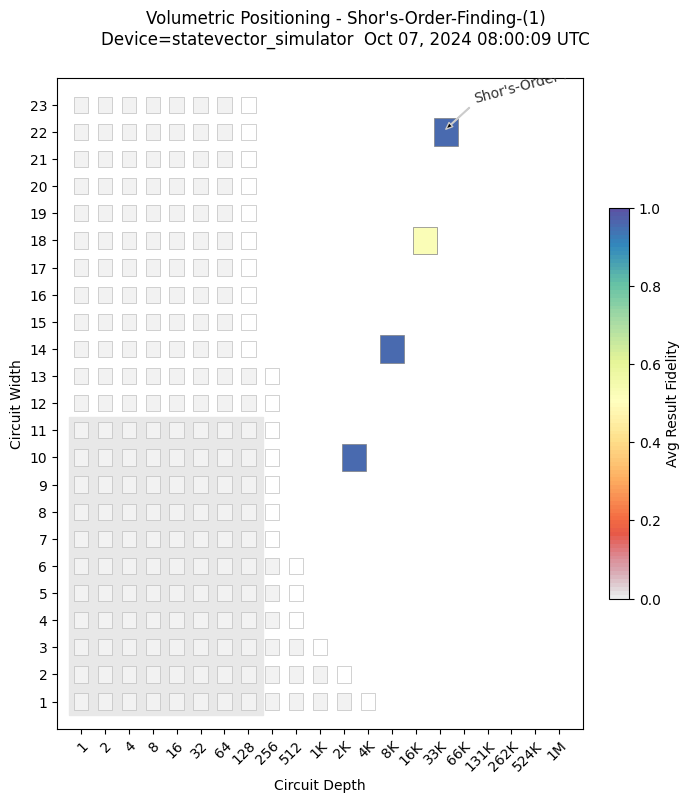

In [4]:
#################### Benchmark Loop        

# Execute program with default parameters
def run (min_qubits=10, max_circuits=1, max_qubits=22, num_shots=1000, method = 1,  # taking more than 2-3 days after 22qubits
        verbose=verbose, backend_id='statevector_simulator', provider_backend=None,
        hub="ibm-q", group="open", project="main", exec_options=None,
        context=None):

    print(f"{benchmark_name} ({method}) Benchmark - Qiskit")

    # Each method has a different minimum amount of qubits to run and a certain multiple of qubits that can be run
    qubit_multiple = 2                  #Standard for Method 2 and 3

    max_qubits = max(max_qubits, min_qubits)        # max must be >= min

    if method == 1:
        min_qubits = max(min_qubits, 10)            # need min of 10
        qubit_multiple = 4
    elif method ==2:
        min_qubits = max(min_qubits, 7)             # need min of 7
    elif method == 3:
        min_qubits = max(min_qubits,6)              # need min of 6

    #skip_qubits = max(1, skip_qubits)
    
    if max_qubits < min_qubits:
        print(f"Max number of qubits {max_qubits} is too low to run method {method} of {benchmark_name}")
        return

    # create context identifier
    if context is None: context = f"{benchmark_name} ({method}) Benchmark"
    
    ##########
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler # number_order contains an array of length 2 with the number and order
    def execution_handler(qc, result, num_qubits, number_order, num_shots):
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        #Must convert number_order from string to array
        order = eval(number_order)[1]
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, order, num_shots, method)
        metrics.store_metric(num_qubits, number_order, 'fidelity', fidelity)
    
    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id, provider_backend=provider_backend,
            hub=hub, group=group, project=project, exec_options=exec_options,
            context=context)
 
    ##########
    
    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, qubit_multiple):

        input_size = num_qubits - 1

        if method == 1: num_bits = int((num_qubits -2)/4)
        elif method == 2: num_bits = int((num_qubits -3)/2)
        elif method == 3: num_bits = int((num_qubits -2)/2)

        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (input_size), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")

        for _ in range(num_circuits):

            base = 1
            while base == 1:
                # Ensure N is a number using the greatest bit
                number = np.random.randint(2 ** (num_bits - 1) + 1, 2 ** num_bits)
                order = np.random.randint(2, number)
                base = generate_base(number, order)

            # Checking if generated order can be reduced. Can also run through prime list in shors utils
            if order % 2 == 0: order = 2
            if order % 3 == 0: order = 3

            number_order = (number, order)

            if verbose: print(f"Generated {number=}, {base=}, {order=}")

            # create the circuit for given qubit size and order, store time metric
            ts = time.time()
            qc = ShorsAlgorithm(number, base, method=method, verbose=verbose)
            metrics.store_metric(num_qubits, number_order, 'create_time', time.time()-ts)

            # collapse the 4 sub-circuit levels used in this benchmark (for qiskit)
            qc = qc.decompose().decompose().decompose().decompose()

            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, number_order, num_shots)

        # Wait for some active circuits to complete; report metrics when groups complete
        ex.throttle_execution(metrics.finalize_group)

    # Wait for all active circuits to complete; report metrics when groups complete
    ex.finalize_execution(metrics.finalize_group)

    ##########
    
    # print the last circuit created
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nControlled Ua Operator 'cUa' ="); print(CUA_ if CUA_ != None else " ... too large!")
    print("\nControlled Multiplier Operator 'cMULTamodN' ="); print(CMULTAMODN_ if CMULTAMODN_!= None else " ... too large!")
    print("\nControlled Modular Adder Operator 'ccphiamodN' ="); print(CCPHIADDMODN_ if CCPHIADDMODN_ != None else " ... too large!")
    print("\nPhi Adder Operator '\u03C6ADD' ="); print(PHIADD_ if PHIADD_ != None else " ... too large!")
    print("\nQFT Circuit ="); print(QFT_ if QFT_ != None else "  ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics(f"Benchmark Results - {benchmark_name} ({method}) - Qiskit")

    
# if main, execute method
if __name__ == '__main__': run() #max_qubits = 6, max_circuits = 5, num_shots=100)